# Finding Anomalous gas absorbtion in MORFs
Under certain circumstances the amount of gas stored in a MORF can increase as temperature increases, this is very cool as it never occurs in a MOF without a ring.

Starting with the grand canonical ensemble, the  probability of a state is as follows:
$$P_i =\displaystyle\sum^{all states} \frac{e^{\beta(\mu N_i-E_i)}}{Z}$$

Assuming that there are four possibe states, corresponding to two ring positions and the prescence of gas the probabilty of a state can be written as:
$$P(n,r)=\frac{e^{\beta(\mu n − r\delta−n(r\epsilon_{\heartsuit} + (1−r)\epsilon_{\triangle}}}{1 +  e^{−\beta \delta} + e^{\beta(\mu−\epsilon_{\triangle})} + e^{\beta(\mu − \epsilon_{\heartsuit} − \delta)}}$$

This makes the probability of a state in our MORF:
$$P(n,r)=\frac{e^{\beta(\mu n − r\delta−n(r\epsilon_{\heartsuit} + (1−r)\epsilon_{\triangle}}}{1 +  e^{−\beta \delta} + e^{\beta(\mu−\epsilon_{\triangle})} + e^{\beta(\mu − \epsilon_{\heartsuit} − \delta)}}$$

Uisng the concept of thermal averages, the expectation value of n is:
$$<n> = \frac{e^{\beta(\mu−\epsilon_{\triangle})} + e^{\beta(\mu − \epsilon_{\heartsuit} − \delta)}}{1 +  e^{−\beta \delta} + e^{\beta(\mu−\epsilon_{\triangle})} + e^{\beta(\mu − \epsilon_{\heartsuit} − \delta)}}$$

Which can in turn be written as 
$$\langle n \rangle = \frac{\lambda k}{1+\lambda k}$$

where $\lambda = e^{\beta \mu}$ and  $k = \frac{e^{−\beta \epsilon_\triangle} + e^{− \beta(\delta + \epsilon_\heartsuit))}}{1+e^{−\beta \delta}}$. 

For the correct choice of $\delta$ , $\epsilon_\heartsuit$, and $\epsilon_\triangle$ the derivative of $\langle n \rangle$ with regards to temperature, as we will now show. Note that we will use the $\beta$ derivative as it is mathematically less clunky and conveniently unitless.

Let's find $\frac{\partial \langle n \rangle}{\partial \beta} < 0$

In [2]:
using ForwardDiff
using Printf
using PyPlot
using DataFrames
using DelimitedFiles
using CSV
PyPlot.matplotlib.style.use("Solarize_Light2") # dope style

#output variables
resolution = 10
β_test = 7.0
μ_test = 4.0
#remember to change in python script aswell
#
#
#
#

struct Material
    δ::Float64
    ϵ♡::Float64
    ϵΔ::Float64
end

function Base.show(io::IO, material::Material)
    @printf("MORF material with:\n\tδ = %.3f\n\tϵ♡ = %.3f\n\tϵΔ = %.3f\n", material.δ, material.ϵ♡, material.ϵΔ)
end

function K(β::Real, material::Material) # must assert β::Real as opposed to β::Float64 for ForwardDiff.jl to work
    p = 1 / (1 + exp(-β * material.δ)) # probability ring is on ♡ when gas is absent
    return p * exp(-β * material.ϵΔ) + (1 - p) * exp(-β * material.ϵ♡)
end

function λ(μ::Real, β::Real) # must assert β::Real as opposed to β::Float64 for ForwardDiff.jl to work
    return exp(β*μ)
end
    
function N(μ::Real,β::Real, material::Material)# must assert β::Real as opposed to β::Float64 for ForwardDiff.jl to work
    numerator = λ(μ,β)*K(β,material)
    denominator = 1 + λ(μ,β)*K(β,material)
    return numerator/denominator
end

N (generic function with 1 method)

Now in order to identify where in material space anomalous behavior occurs we'll utilize automatic differentation to find $\frac{\partial \langle n \rangle}{\partial \beta}$.

In [3]:
function ∂N_∂β(μ,β::Float64, material::Material)#using ⟨n⟩ in the function name triggers a syntax errror
    # view K as a function of β only.
    N_of_β(x) = N(μ, x[1], material) # x plays role of β
    ∂N_∂β_of_β = x -> ForwardDiff.gradient(N_of_β, x) # x plays role of β
    return ∂N_∂β_of_β([β])[1]
end

∂N_∂β (generic function with 1 method)

In [5]:
nb_pts = resolution
#range we'll search over
δ_range = range(0.0, stop=4.0, length=nb_pts)
ϵ♡_range = range(-4.0, stop=0.0, length=nb_pts)
ϵΔ_range = range(-4.0, stop=0.0, length=nb_pts)
β_range = range(0.01, stop=10.0, length=nb_pts)
μ_range = range(0.01, stop=5.0, length=nb_pts)
#data size
indexing_var = 1
for δ in δ_range
    for ϵ♡ in ϵ♡_range
        for ϵΔ in ϵΔ_range
            material = Material(δ, ϵ♡, ϵΔ)
            if ∂N_∂β(μ_test,β_test, material)<0.0
                indexing_var += 1
            end
        end
    end
end
#data storage
valid_δ = zeros(Float64, indexing_var)
valid_ϵ♡ = zeros(Float64, indexing_var)
valid_ϵΔ = zeros(Float64, indexing_var)
roc = zeros(Float64, indexing_var)

indexing_var = 1
for δ in δ_range
    for ϵ♡ in ϵ♡_range
        for ϵΔ in ϵΔ_range
            material = Material(δ, ϵ♡, ϵΔ)
            if ∂N_∂β(μ_test,β_test, material)<0.0
                roc[indexing_var] = ∂N_∂β(μ_test,β_test, material)
                valid_δ[indexing_var] = δ
                valid_ϵ♡[indexing_var] = ϵ♡
                valid_ϵΔ[indexing_var] = ϵΔ
                indexing_var += 1
            end
        end
    end
end

df = DataFrame()
df.δ = valid_δ
df.ϵ♡ =  valid_ϵ♡
df.ϵΔ = valid_ϵΔ
df.∂n_∂β = roc

filename= "Anomalous_behavior_at_beta=$(β_test)_and_mu=$(μ_test)_res=$(resolution).csv"

CSV.write(filename,  DataFrame(df), writeheader=true)

"Anomalous_behavior_at_beta=7.0_and_mu=4.0_res=10.csv"

Visit is being a pain so I'm going to attmept to visualize data in another manner. This is a python library called Seaborn. Unfortunately Julia and pandas(which Seaborn is an extension of) differ in how they view dataframes, and as such we have to go between python and Julia.

<Figure size 432x288 with 0 Axes>

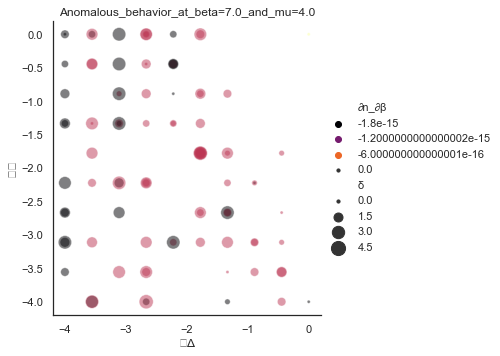

In [9]:
#output data, same as above
resolution = 10
β_test = 7.0
μ_test = 4.0
#remember to change above
#
#
#
#

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline
sns.set(style="white")

filename = "Anomalous_behavior_at_beta=" + str(β_test) + "_and_mu=" + str(μ_test) + "_res=" + str(resolution) + ".csv"

anomaly = pd.read_csv(filename) 

# print(data.δ)

plt.figure()
plt.rcParams['figure.figsize'] = [20, 10]
sns.relplot(x="ϵΔ", y="ϵ♡",
                     hue="∂n_∂β", size="δ",
                     palette='inferno', alpha=.5, sizes=(10, 200),
                     data=anomaly)
plt.title("Anomalous_behavior_at_beta=" + str(β_test) + "_and_mu=" + str(μ_test))
plt.show()